In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# ---------------------------
# Define the neural network
# ---------------------------
class FCNet(nn.Module):
    def __init__(self, layers):
        super(FCNet, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)

In [4]:
# ---------------------------
# Define the PDE residual
# ---------------------------
def f(x):  # RHS: source term
    return (np.pi ** 2) * torch.sin(np.pi * x)

def pde_residual(model, x):
    if x.requires_grad == 0:
        x.requires_grad == True
    T = model(x)

    # First derivative
    dT = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    # Second derivative
    d2T = torch.autograd.grad(dT, x, grad_outputs=torch.ones_like(dT), create_graph=True)[0]

    return d2T + f(x)

In [5]:
# ---------------------------
# Training setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layers = [1, 20, 20, 1]
model = FCNet(layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

# Collocation points
x_collocation = torch.linspace(0, 1, 100, requires_grad=True).view(-1, 1).to(device)
x_bc = torch.tensor([[0.0], [1.0]], requires_grad=True).to(device)

In [6]:
# ---------------------------
# Training loop
# ---------------------------
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE Loss
    res = pde_residual(model, x_collocation)
    loss_phys = torch.mean(res**2)

    # Boundary Conditions Loss
    T_bc = model(x_bc)
    loss_bc = torch.mean(T_bc**2)

    # Total loss
    loss = loss_phys + loss_bc
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 47.812199
Epoch 500, Loss: 0.009925
Epoch 1000, Loss: 0.000559
Epoch 1500, Loss: 0.000482
Epoch 2000, Loss: 0.000396
Epoch 2500, Loss: 0.000305
Epoch 3000, Loss: 0.000217
Epoch 3500, Loss: 0.000144
Epoch 4000, Loss: 0.000095
Epoch 4500, Loss: 0.000071


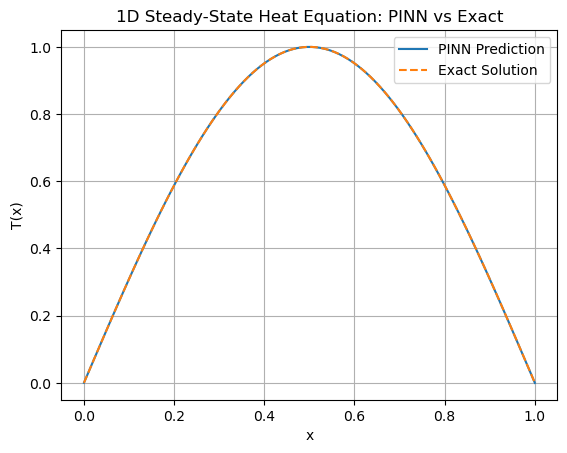

In [7]:
# ---------------------------
# Plotting the result
# ---------------------------
x_test = torch.linspace(0, 1, 100).view(-1,1).to(device)
T_pred = model(x_test).detach().cpu().numpy()
x_test_np = x_test.cpu().numpy()
T_exact = np.sin(np.pi * x_test_np)

plt.plot(x_test_np, T_pred, label="PINN Prediction")
plt.plot(x_test_np, T_exact, '--', label="Exact Solution")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.title("1D Steady-State Heat Equation: PINN vs Exact")
plt.grid()
plt.show()